In [49]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import wave
import warnings
warnings.filterwarnings('ignore')

In [50]:
#GAN-Style Image Generator

class Generator(nn.Module):
    """Improved Generator with BatchNorm and LeakyReLU"""
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [52]:
generator = Generator().to(device)
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [53]:
# Generate synthetic images
with torch.no_grad():
    noise = torch.randn(10, 100).to(device)
    synthetic_images = generator(noise).cpu().numpy()

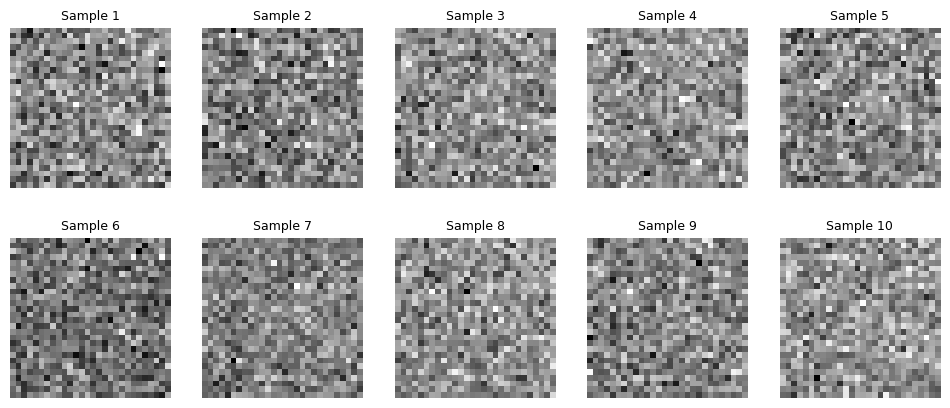

In [54]:
# Visualize generated images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = synthetic_images[i].reshape(28, 28)
    # Normalize to [0, 1] for better visualization
    img = (img + 1) / 2
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Sample {i+1}", fontsize=9)


In [55]:
plt.suptitle("GAN-Style Generated Images", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✅ Generated {len(synthetic_images)} synthetic images")

<Figure size 640x480 with 0 Axes>

✅ Generated 10 synthetic images


In [56]:
print("Loading T5 model for text augmentation...")

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
model.eval()
model.to(device)

Loading T5 model for text augmentation...


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [57]:
# Original texts
texts = [
    "The weather is sunny.",
    "I love playing football."
]

In [58]:
print(f"\nOriginal texts:")
for i, text in enumerate(texts, 1):
    print(f"  {i}. {text}")


Original texts:
  1. The weather is sunny.
  2. I love playing football.


In [59]:
# Prepare inputs with translation prompt for better augmentation
augmented_inputs = [f"translate English to German: {text}" for text in texts]

In [60]:
inputs = tokenizer(
    augmented_inputs,
    return_tensors="pt",
    padding=True,
    truncation=True
).to(device)

In [61]:
# Generate augmented text
with torch.no_grad():
    outputs = model.generate(
        inputs["input_ids"],
        max_length=30,
        do_sample=True,
        top_k=50,
        top_p=0.95,  # Added nucleus sampling
        temperature=0.8,  # Slightly lower temperature for more coherent output
        num_return_sequences=3,
        num_beams=1  # Disable beam search for diversity
    )

In [62]:
augmented_texts = [
    tokenizer.decode(o, skip_special_tokens=True)
    for o in outputs
]

In [63]:
print(f"\n✅ Generated {len(augmented_texts)} augmented text samples:")
for i, text in enumerate(augmented_texts, 1):
    print(f"  {i}. {text}")


✅ Generated 6 augmented text samples:
  1. Das Wetter ist sonnig.
  2. Das Wetter ist sonnig.
  3. Das Wetter ist sonnig.
  4. Ich liebe den Fußballspielen.
  5. Ich spiele gerne Fußball.
  6. Ich nehme es gerne an, Fußball zu spielen.


In [64]:
print("Generating synthetic audio...")

sample_rate = 16000
duration = 2.0  # seconds

# Create time array
t = torch.linspace(0, duration, int(sample_rate * duration))

Generating synthetic audio...


In [65]:
# Generate richer waveform with multiple harmonics
fundamental_freq = 440  # A4 note
waveform = (
    0.5 * torch.sin(2 * math.pi * fundamental_freq * t) +  # Fundamental
    0.3 * torch.sin(2 * math.pi * fundamental_freq * 2 * t) +  # 2nd harmonic
    0.2 * torch.sin(2 * math.pi * fundamental_freq * 3 * t) +  # 3rd harmonic
    0.1 * torch.sin(2 * math.pi * fundamental_freq * 4 * t) +  # 4th harmonic
    0.02 * torch.randn(t.shape)  # Reduced noise
)

In [66]:
# Apply fade in/out to avoid clicks
fade_samples = int(sample_rate * 0.01)  # 10ms fade
fade_in = torch.linspace(0, 1, fade_samples)
fade_out = torch.linspace(1, 0, fade_samples)

In [67]:
waveform[:fade_samples] *= fade_in
waveform[-fade_samples:] *= fade_out
waveform = waveform.unsqueeze(0) 


In [68]:
def save_wav(filename, waveform, sample_rate):
    """Save waveform to WAV file"""
    audio = waveform.squeeze().cpu().numpy()
    
    # Normalize to prevent clipping
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val * 0.95  # Leave headroom
    
    # Convert to int16
    audio_int16 = np.int16(audio * 32767)
    
    with wave.open(filename, "w") as wf:
        wf.setnchannels(1)  # Mono
        wf.setsampwidth(2)  # 16-bit PCM
        wf.setframerate(sample_rate)
        wf.writeframes(audio_int16.tobytes())
    
    print(f"✅ Audio saved: {filename}")
    print(f"   - Duration: {duration}s")
    print(f"   - Sample rate: {sample_rate} Hz")
    print(f"   - Channels: Mono")

In [69]:
save_wav("synthetic_audio.wav", waveform, sample_rate)

✅ Audio saved: synthetic_audio.wav
   - Duration: 2.0s
   - Sample rate: 16000 Hz
   - Channels: Mono


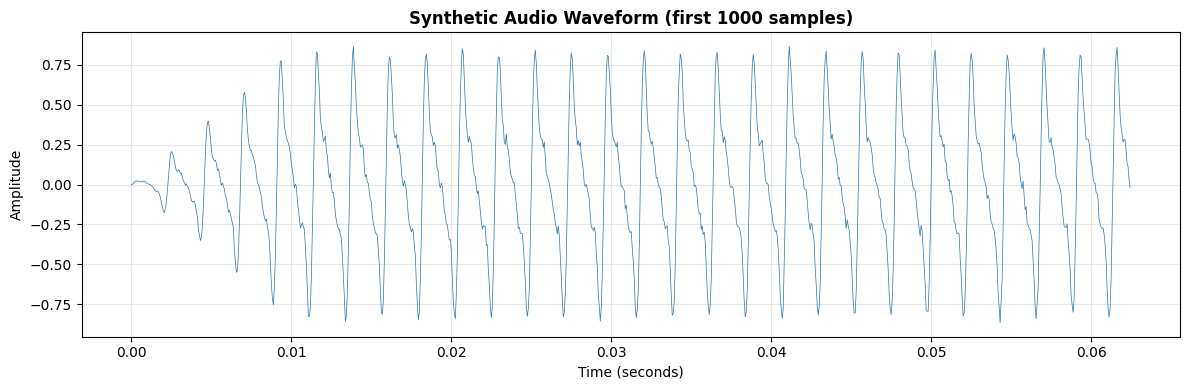

✅ All synthetic data generation completed!


In [70]:
# Visualize the waveform
plt.figure(figsize=(12, 4))
time_array = np.linspace(0, duration, len(waveform.squeeze()))
plt.plot(time_array[:1000], waveform.squeeze().numpy()[:1000], linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Synthetic Audio Waveform (first 1000 samples)", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ All synthetic data generation completed!")